In [1]:
import os
import pandas as pd
import numpy as np

In [2]:
dataPath = '../myMediapipe/trainingData/staticGestures/210316_1115'

In [3]:
!ls $dataPath

closedPalm.csv	index.csv	       labels.csv    static_gestures_labels.txt
fist.csv	indexAnularClosed.csv  openPalm.csv  test.csv
gun.csv		indexAnularOpen.csv    scissors.csv  thumbIndexAnularOpen.csv


In [4]:
labelsFile = os.path.join(dataPath, "labels.csv")
labels = pd.read_csv(labelsFile,header=None)
print(labels)

                         0                     1  2
0                Open Palm              openPalm  0
1              Closed Palm            closedPalm  1
2                     Fist                  fist  2
3             Index Finger                 index  3
4        Index Anular Open       indexAnularOpen  4
5      Index Anular Closed     indexAnularClosed  5
6  Thumb Index Anular Open  thumbIndexAnularOpen  6
7                 Scissors              scissors  7


In [5]:
preData  = {}
for label in labels.itertuples():
    trainingFile = os.path.join(dataPath,label[2] + ".csv")
    preData[label.Index] = pd.read_csv(trainingFile,header=None)
    print("Loading file:", trainingFile, "\tNumber of Rows:" , len(preData[label.Index].index))
    print(label.Index)

Loading file: ../myMediapipe/trainingData/staticGestures/210316_1115/openPalm.csv 	Number of Rows: 40221
0
Loading file: ../myMediapipe/trainingData/staticGestures/210316_1115/closedPalm.csv 	Number of Rows: 34870
1
Loading file: ../myMediapipe/trainingData/staticGestures/210316_1115/fist.csv 	Number of Rows: 36174
2
Loading file: ../myMediapipe/trainingData/staticGestures/210316_1115/index.csv 	Number of Rows: 43561
3
Loading file: ../myMediapipe/trainingData/staticGestures/210316_1115/indexAnularOpen.csv 	Number of Rows: 42852
4
Loading file: ../myMediapipe/trainingData/staticGestures/210316_1115/indexAnularClosed.csv 	Number of Rows: 37798
5
Loading file: ../myMediapipe/trainingData/staticGestures/210316_1115/thumbIndexAnularOpen.csv 	Number of Rows: 38443
6
Loading file: ../myMediapipe/trainingData/staticGestures/210316_1115/scissors.csv 	Number of Rows: 35471
7


In [6]:
# cleaning
for key in preData.keys():
    print("Record #:", key, "\thas:",len(preData[key].index) % 21, "incomplete captures")
    preData[key].drop(preData[key].tail(len(preData[key].index) % 21).index,inplace=True)

Record #: 0 	has: 6 incomplete captures
Record #: 1 	has: 10 incomplete captures
Record #: 2 	has: 12 incomplete captures
Record #: 3 	has: 7 incomplete captures
Record #: 4 	has: 12 incomplete captures
Record #: 5 	has: 19 incomplete captures
Record #: 6 	has: 13 incomplete captures
Record #: 7 	has: 2 incomplete captures


In [7]:
# balance data
recordsPerClass = len(preData[0].index) #initial value
#Calculate smallest class
for key in preData.keys():
    if recordsPerClass > len(preData[key].index): 
        recordsPerClass=len(preData[key].index)
    #print(recordsPerClass)

#Trimming
for key in preData.keys():
    preData[key] = preData[key].head(recordsPerClass)
    print(len(preData[key].index))

34860
34860
34860
34860
34860
34860
34860
34860


In [8]:
# Builds training and label array

In [9]:
numTrainRows, numTestRows = 0,0
numLandmaks = 21
numCols = numLandmaks*2

def countRows(dataDict):
    rowsCount=0
    for key in dataDict.keys():
        rowsCount += len(dataDict[key].index)
    return rowsCount

numRows = countRows(preData)
#numTestRows = countRows(testData)

numTransRows = int(numRows / numLandmaks)
transData = np.zeros((numTransRows,numCols),preData[1][4].dtypes)
transLabels = np.zeros((numTransRows),np.int16)

#numTestRows = int(numTestRows / numLandmaks)
#testingData = np.zeros((numTestRows,numCols),preData[1][4].dtypes)
#testingLabels = np.zeros((numTestRows),np.int16)

print("Number of Rows in total:", numTransRows)  
print(transData.shape, transData.dtype)
print(transLabels.shape, transLabels.dtype)

#print(testingData.shape, testingData.dtype)
#print(testingLabels.shape, testingLabels.dtype)


Number of Rows in total: 13280
(13280, 42) float64
(13280,) int16


In [10]:
def transposeInterleave(a, b):
    c = np.empty((a.size + b.size,), dtype=a.dtype)
    c[0::2] = a
    c[1::2] = b
    return c

def dataTransp(dataDict,processedData,processedLabels):
    j = 0
    for key in dataDict.keys():
        for i in range(0, len(dataDict[key].index), numLandmaks):  
            #print(dataDict[1].iloc[i : i + numLandmaks,3:5])
            a= np.ravel(np.asarray(dataDict[key].iloc[i : i + numLandmaks,3:4]))
            b= np.ravel(np.asarray(dataDict[key].iloc[i : i + numLandmaks,4:5]))
            #print("j:",j)
            processedData[j] = transposeInterleave(a,b)
            processedLabels[j] =labels.iloc[key,2]
            j+=1
     # retun True

dataTransp(preData,transData,transLabels) 

print(transData[-1])
print(transLabels[-1])

[ 0.991188  0.        0.       -0.731462 -1.454655  0.       -2.472789
  0.        0.        0.        0.        0.83008   3.112623  0.
 -3.089024  0.        0.        0.        0.        2.647737 -3.005331
  0.       -3.133602  0.        0.        0.        0.       -0.422794
 -0.562422  0.       -2.883348  0.        0.        0.        0.
  0.       -1.362249  0.       -2.965212  0.        0.        0.      ]
7


In [11]:
# Labels to one hot

In [12]:
from keras.utils import to_categorical
print(transLabels.shape)
transLabels = to_categorical(transLabels)
print(transLabels.shape)
print(transLabels[-1])

(13280,)
(13280, 8)
[0. 0. 0. 0. 0. 0. 0. 1.]


In [13]:
# Set apart Test Data

In [14]:
from sklearn.model_selection import train_test_split
testDataRatio = 0.2

X_train, X_test, y_train, y_test = train_test_split(transData,transLabels, test_size=testDataRatio)
print( "\tTraining records:", np.shape(X_train)[0], "\tTest records:", np.shape(X_test)[0])

	Training records: 10624 	Test records: 2656


In [15]:
# model definition

In [16]:
from keras import models
from keras import layers
from keras import backend as K
K.clear_session()

model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(numCols,)))
model.add(layers.Dense(42, activation='relu'))
model.add(layers.Dense(len(labels.index), activation='softmax'))

In [17]:
# model compile

In [18]:
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [19]:
# training

In [20]:
history = model.fit(X_train,
                    y_train,
                    epochs=40,
                    #batch_size=512,
                    validation_split=0.2)

Epoch 1/40
266/266 [==============================] - 1s 2ms/step - loss: 1.3803 - accuracy: 0.5255 - val_loss: 1.0462 - val_accuracy: 0.6428
Epoch 2/40
266/266 [==============================] - 0s 2ms/step - loss: 0.8604 - accuracy: 0.7188 - val_loss: 0.7314 - val_accuracy: 0.7689
Epoch 3/40
266/266 [==============================] - 0s 2ms/step - loss: 0.6336 - accuracy: 0.8036 - val_loss: 0.5806 - val_accuracy: 0.8212
Epoch 4/40
266/266 [==============================] - 0s 2ms/step - loss: 0.5077 - accuracy: 0.8388 - val_loss: 0.4985 - val_accuracy: 0.8315
Epoch 5/40
266/266 [==============================] - 0s 2ms/step - loss: 0.4279 - accuracy: 0.8693 - val_loss: 0.4193 - val_accuracy: 0.8711
Epoch 6/40
266/266 [==============================] - 0s 2ms/step - loss: 0.3737 - accuracy: 0.8878 - val_loss: 0.4002 - val_accuracy: 0.8781
Epoch 7/40
266/266 [==============================] - 0s 2ms/step - loss: 0.3362 - accuracy: 0.8988 - val_loss: 0.3592 - val_accuracy: 0.8885
Epoch 

In [21]:
# Plotting the training and validation loss

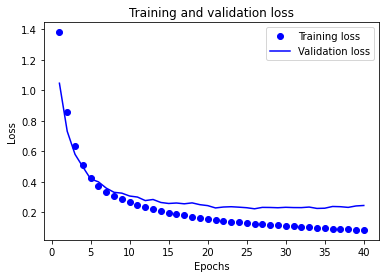

In [22]:
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [23]:
# Plotting the training and validation accuracy

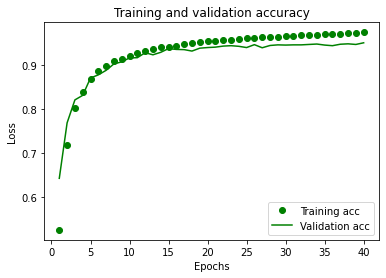

In [24]:
plt.clf()
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'go', label='Training acc')
plt.plot(epochs, val_acc, 'g', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [25]:
# Evaluate the model

In [26]:
loss, acc = model.evaluate(X_test, y_test, verbose=0)
print('\nTesting loss: {}%, acc: {}%\n'.format(round(loss*100,2),round(acc*100,2)))


Testing loss: 24.15%, acc: 95.33%



In [27]:
# TODO: Model optimization

In [28]:
# saving
model.save('gestures003.h5')

In [29]:
# To tflite

In [30]:
import tensorflow as tf
print(tf.version)

converter = tf.lite.TFLiteConverter.from_keras_model(model) 
liteModel = converter.convert()

open("gestures003.tflite", "wb").write(liteModel)

#file = open( 'gestures001.tflite' , 'wb' ) 
#file.write( liteModel )

<module 'tensorflow._api.v2.version' from '/home/nghia/venv/lib/python3.6/site-packages/tensorflow/_api/v2/version/__init__.py'>
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /tmp/tmpb3l8wk1x/assets


24984